In [1]:
import torch
from torch.utils import data
from torchvision import transforms
import numpy as np
import datetime
import matplotlib.pyplot as plt
from models.stclassifier import dLtae
from models.ltae import LTAE

from utils import load_npz
import json
import os
import time
import random

In [2]:
# from dataset import SITSData

In [3]:
def plot_curve(data, title):
    """
    data: path to Json file
    title: title of the plot
    """
    data = json.load(open(data))
    epoch =range(1, len(data)+1)
    
    # Loss
    train_loss = [data[str(i)]['train_loss'] for i in epoch]
    val_loss = [data[str(i)]['val_loss'] for i in epoch]

    # Accuracy
    train_accuracy = [data[str(i)]['train_accuracy'] for i in epoch]
    val_accuracy = [data[str(i)]['val_accuracy'] for i in epoch]

    def get_max():
        """
        Get max accuracy and epoch
        """
        max_train_accuracy = max(train_accuracy)
        max_train_epoch = train_accuracy.index(max_train_accuracy)
        max_val_accuracy = max(val_accuracy)
        max_val_epoch = val_accuracy.index(max_val_accuracy)
        return max_train_accuracy, max_train_epoch, max_val_accuracy, max_val_epoch

    max_train_accuracy, max_train_epoch, max_val_accuracy, max_val_epoch = get_max()

    # plot loss and accuracy in separate figure axis
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,5))
    ax1.plot(epoch, train_loss, label='train loss')
    ax1.plot(epoch, val_loss, label='val loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Accuracy
    ax2.plot(epoch, train_accuracy, label='train accuracy')
    ax2.plot(epoch, val_accuracy, label='val accuracy')
    
    # plot max_train_epoch and max_val_epoch point
    ax2.scatter(max_train_epoch, max_train_accuracy)
    ax2.scatter(max_val_epoch, max_val_accuracy)
    # plot max train and val accuracy
    ax2.annotate('max: %.2f at %.fth epoch' % (max_train_accuracy, max_train_epoch), xy=(max_train_epoch, max_train_accuracy), xytext=(max_train_epoch, max_train_accuracy+0.01))
    ax2.annotate('max: %.2f at %.fth epoch' % (max_val_accuracy, max_val_epoch), xy=(max_val_epoch, max_val_accuracy), xytext=(max_val_epoch, max_val_accuracy+0.01))
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    fig.suptitle(title)
    # fig.tight_layout()
    plt.savefig(os.path.join('./charts', title + '.png'),dpi=1500, transparent=False)
    plt.show()
    # plt.close()

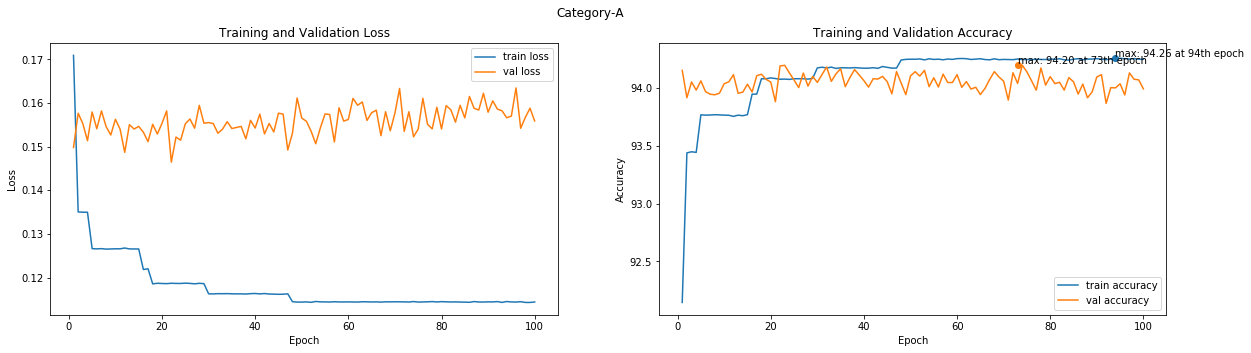

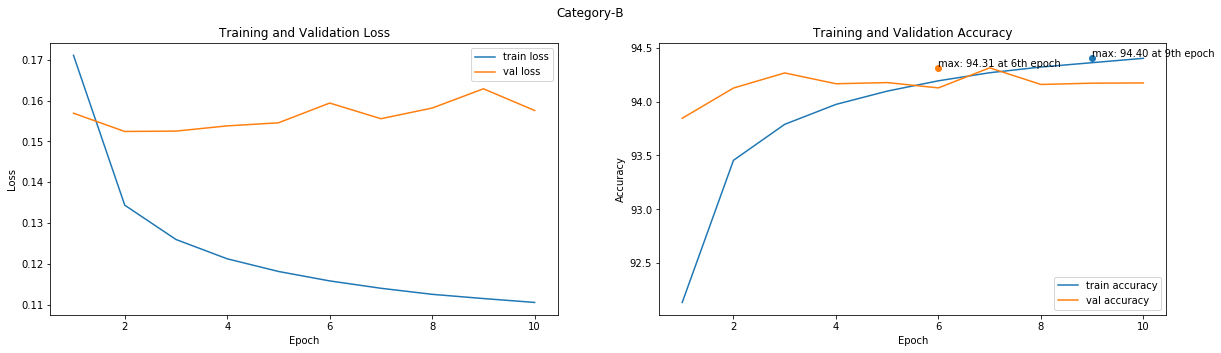

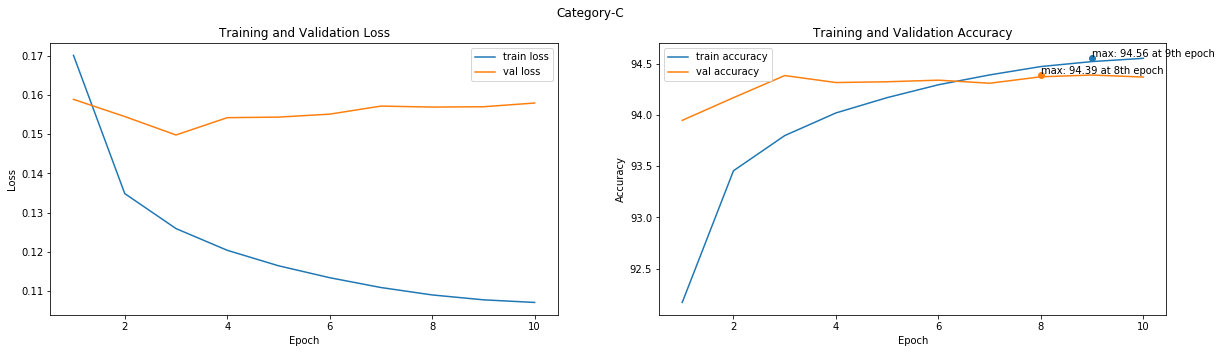

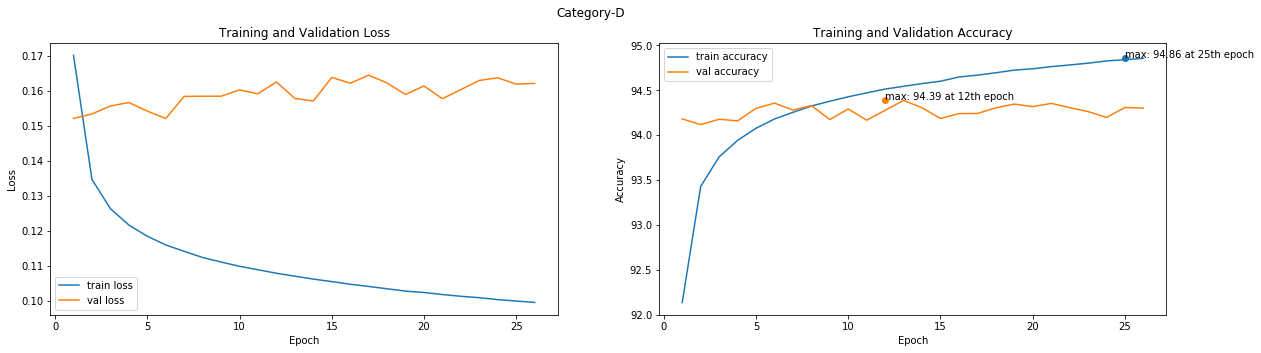

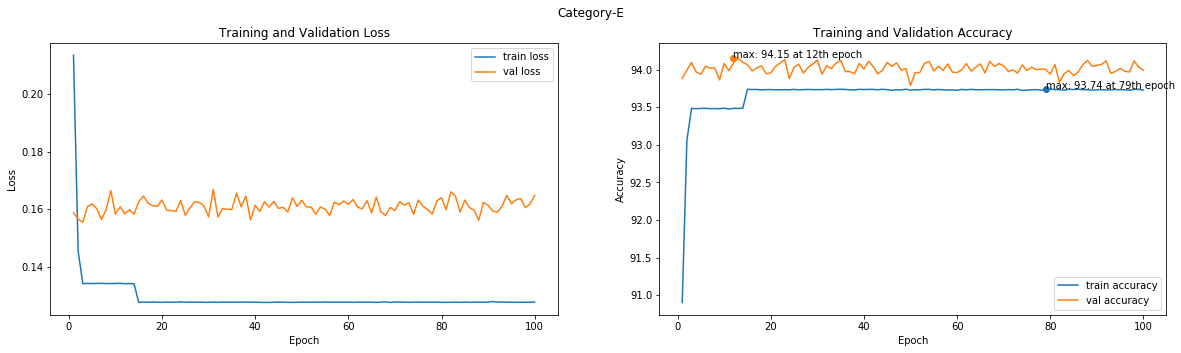

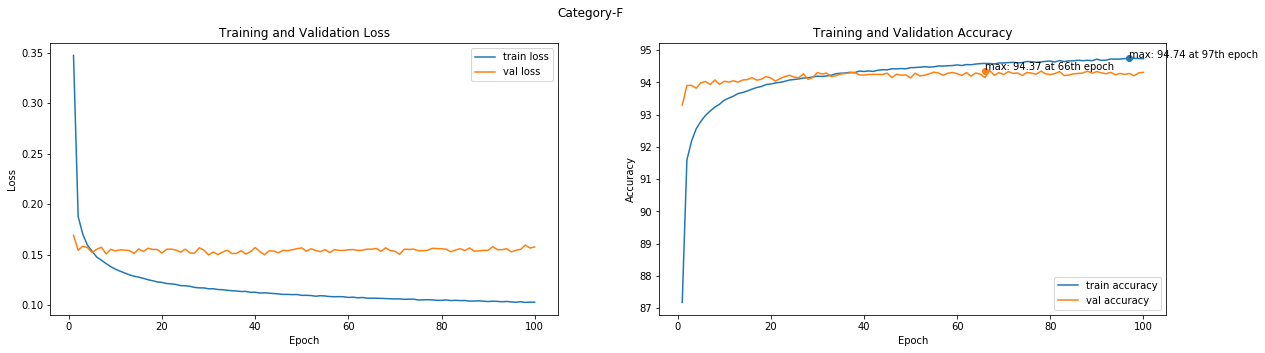

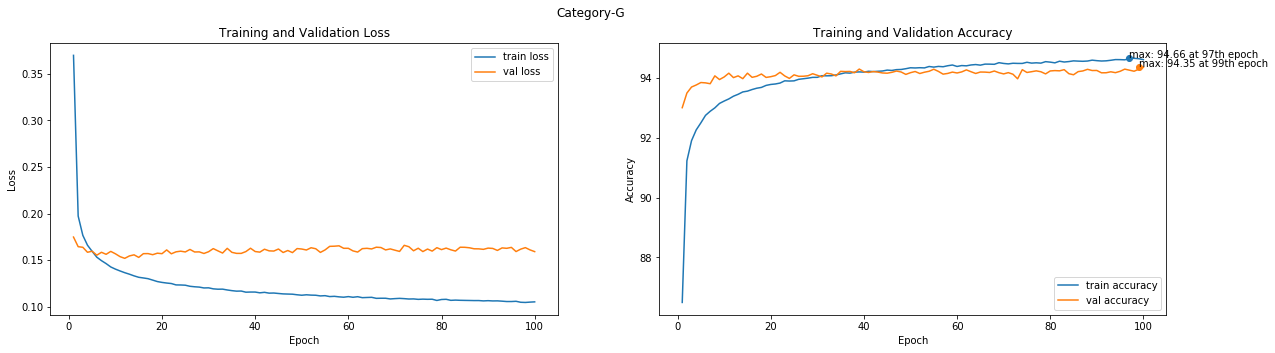

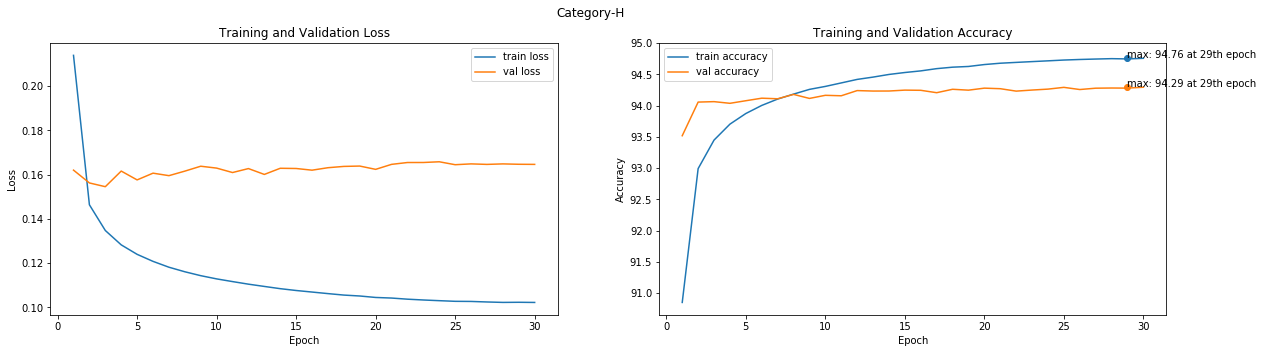

In [5]:
files = ["../../../results/ltae/results/Seed_0/trainlog.json", 
         "../../../results/ltae/results/2018/Seed_0/seed_0_batch_128_epoch_10_lr_0.01_trainlog.json", 
         "../../../results/ltae/results/2018/Seed_0/seed_0_batch_128_epoch_10_lr_0.001_sch_trainlog.json", 
         "../../../results/ltae/results/2018/Seed_0/seed_0_batchsize_128_epochs_35_factor_84253_trainlog.json",
         "../../../results/ltae/trials/Seed_0/trainlog.json",
        "../../../results/ltae/results/2018/Seed_0/seed_0_batchsize_2048_epochs_100_fator_1300_trainlog.json",
         "../../../results/ltae/results/2018/Seed_0/seed_0_batchsize_2048_epochs_100_factor_1000_trainlog.json",
         "../../../results/ltae/results/2018/Seed_0/seed_0_batchsize_2048_epochs_30_factor_5266_trainlog.json"
        ]
category = ["Category-A", "Category-B", "Category-C", 
            "Category-D",
            "Category-E", "Category-F", "Category-G", "Category-H" ]
len(files)
for i in range(len(files)):
    plot_curve(files[i], category[i])
    # break

In [ ]:
m = '../../../results/ltae/trials/Seed_0/model.pth.tar'
state_dict = torch.load(m)['state_dict']

In [ ]:
# state_dict

In [7]:
len(state_dict['temporal_encoder.position_enc.weight'])

34

In [17]:
model = dLtae(in_channels = js['in_channels'], n_head = js['n_head'], d_k= js['d_k'], n_neurons=js['n_neurons'], dropout=js['dropout'], d_model= js['d_model'],
                 mlp = js['mlp4'], T =js['T'], len_max_seq = js['len_max_seq'], 
              positions=None, return_att=False)

In [12]:
model.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
model.eval()

In [23]:
# m = '../../../results/ltae/trials/Seed_0/model.pth.tar'

# model.load_state_dict(torch.load(m))

In [2]:
## write a function to plot the curves
def plot_curve(data):
    data = json.load(open(data))
    
    epoch =range(1, len(data)+1)
    # Loss
    train_loss = [data[str(i)]['train_loss'] for i in epoch]
    val_loss = [data[str(i)]['val_loss'] for i in epoch]
    # Accuracy
    train_accuracy = [data[str(i)]['train_accuracy'] for i in epoch]
    val_accuracy = [data[str(i)]['val_accuracy'] for i in epoch]
    # IOU
    # train_IoU = [data[str(i)]['train_IoU'] for i in epoch]
    # val_IoU = [data[str(i)]['val_IoU'] for i in epoch]

In [5]:
def date_positions(gfdate_path):
    with open(gfdate_path, "r") as f:
        out_date_list = f.readlines()
    out_date_list = [x.strip() for x in out_date_list]
    out_date_list = [datetime.datetime.strptime(x, "%Y%m%d").timetuple().tm_yday for x in out_date_list]
    string_date_list = [x for x in out_date_list]
    return string_date_list

In [6]:
# st = time.time()
# t = date_positions("dates.txt")
# s = date_positions("dates.txt")
# print(t)
# print(s)
# print("time: ", time.time() - st)

In [7]:
n_channel = 10

In [8]:
def generate_ids():
    """
    Descr: 
        Aim: To write and returns the partition (Train, Validation and Test) ids 
        with respect to the grid split index (range 1 - 100)
        
        - A random seed value is set within a random intger 1-10,
        - the set is spltted into 80:10:10,
        - save into a text file with the seed value used
    """
    # set a random seed value within the range 1 -10 
    start_time = time.time()
    seed_value = 9
    # seed_value = np.random.randint(0,10)
    np.random.seed(seed_value)
    # # block id range 1 - 100 (splitted grid)
    block_range = np.arange(1, 101)

    # Train, Validation and Test
    random.shuffle(block_range)
    train_id = block_range[:60] # 60%
    val_id = block_range[60:80] # 20%
    test_id = block_range[80:] # 20%
    print("Seed value: ", seed_value)
    
    if not os.path.exists("./ids/train_val_eval_seed_" + str(seed_value)+".txt"):
        with open("./ids/train_val_eval_seed_" + str(seed_value)+".txt", "w") as f:
            f.write("Training: " + str(list(train_id)) + "\n")
            f.write("Validation: " + str(list(val_id)) + "\n")
            f.write("Testing: " + str(list(test_id)) + "\n")
            f.close()
    print('Read set ids completed: %s second' % (time.time() - start_time))
generate_ids()

Seed value:  9
Read set ids completed: 0.009698629379272461 second


In [9]:
def read_ids(seed_value):
    """
    Read ids from file
    """
    assert seed_value >= 0 and seed_value <= 10
    
    with open("./ids/train_val_eval_seed_" + str(seed_value)+".txt", "r") as f:
        lines = f.readlines()
        Train_ids = eval(lines[0].split(":")[1])
        Val_ids = eval(lines[1].split(":")[1])
        test_ids = eval(lines[2].split(":")[1])
    return Train_ids, Val_ids, test_ids

In [10]:
Train_ids, Val_ids, test_ids = read_ids(0)

In [9]:
j = Val_ids + test_ids

In [10]:
len(test_ids)

10

In [11]:
test_ids

[80, 39, 18, 65, 81, 8, 94, 76, 93, 32]

In [21]:
j

[79, 82, 34, 30, 46, 20, 9, 7, 23, 45, 80, 39, 18, 65, 81, 8, 94, 76, 93, 32]

In [2]:
def compute_mean_std(source_sits, target_sits, case):
    """
    Descr: Compute mean and std for each channel
    Input: both SITS dataset(.npz) paths
            Case[1 - 3]:
            1 - concatenate both dataset, while 2 & 3 rep source and target respectively
    The data(from N,LxD) is reshaped into (N,D,L);
        where N - pixel, D - Bands (10), L - Time (33)
    
    """
    
    # case = 1: both, case = 2: target, case = 3: target
    if case == 1:
        sits = [source_sits, target_sits]
    elif case == 2:
        sits = source_sits
    elif case == 3:
        sits = target_sits
    else:
        print('Select case between 1-3')
        return None
    
    # if sits is a list, then it's a list of paths
    if isinstance(sits, list):
        # load data
        X_source = np.load(sits[0])['X']
        X_target = np.load(sits[1])['X']
        # concatenate the data
        X = np.concatenate((X_source, X_target), axis=0)
    # if sits is a string, then it's a path
    else: 
        with np.load(sits) as data:
            X = data['X']

    X = X.reshape(X.shape[0], n_channel, int(X.shape[1]/n_channel))
    # compute mean and std
    X_mean = np.mean(X, axis=(0,2))
    X_std = np.std(X, axis=(0,2))
    print('mean shape: ', X_mean.shape)
    print('std shape: ', X_std.shape)
    # save X_mean and X_std sepearately for sits as txt file
    np.savetxt(os.path.join('mean_'+ str(case) +'.txt'), X_mean)
    np.savetxt(os.path.join('std_'+ str(case) +'.txt'), X_std)

# for i in [1,2,3]:
#     start_time = time.time()
#     source_path = "../../../data/theiaL2A_zip_img/output/2018/2018_SITS_data.npz"
#     target_path = "../../../data/theiaL2A_zip_img/output/2019/2019_SITS_data.npz"
#     compute_mean_std(source_path, target_path, i)
#     print("run time: ", time.time() - start_time)

In [3]:
def compute_mean_stdv2(sits, domain='source'):
    """
    Descr: Compute mean and std for each channel
    Input: both SITS dataset(.npz) paths
    The data(from N,LxD) is reshaped into (N,D,L);
        where N - pixel, D - Bands (10), L - Time (33)
    """
    with np.load(sits) as data:
            X = data['X']

    X = X.reshape(X.shape[0], n_channel, int(X.shape[1]/n_channel))
    # compute mean and std
    X_mean = np.mean(X, axis=(0,2))
    X_std = np.std(X, axis=(0,2))
    print('mean shape: ', X_mean.shape)
    print('std shape: ', X_std.shape)
    # save X_mean and X_std sepearately for sits as txt file
    np.savetxt(os.path.join('./mean_std/', domain + '_mean.txt'), X_mean)
    np.savetxt(os.path.join('./mean_std/', domain + '_std.txt'), X_std)

source_path = '../../../data/theiaL2A_zip_img/output/2018/2018_SITS_subset_data.npz'
target_path = '../../../data/theiaL2A_zip_img/output/2019/2019_SITS_subset_data.npz'
# compute_mean_stdv2(source_path, 'source')
# compute_mean_stdv2(target_path, domain = 'target')

In [13]:
class SITSDatav2(data.Dataset):
    def __init__(self, sits, seed, partition='train', transform=None):
        
        self.sits = sits
        self.seed = seed
        self.transform = transform
        
        # get partition ids using the read_id() func
        start_time = time.time()
        self.train_ids, self.val_ids, self.test_ids = read_ids(self.seed)
        print("read ids completed: %s second" % (time.time() - start_time))

        # select partition
        if partition == 'train':
            self.ids = self.train_ids
        elif partition == 'val':
            self.ids = self.val_ids
        elif partition == 'test':
            self.ids = self.test_ids
        else:
            raise ValueError('Invalid partition: {}'.format(partition))
        
        start_time = time.time()
        print('reading files....')
        X, y, block_ids = load_npz(self.sits)
        print("load npz: %s seconds" % (time.time() - start_time))
        
        start_time = time.time()
        y = np.unique(y, return_inverse=True)[1]
        print("reassigning %s seconds" % (time.time() - start_time))
        
        # concatenate the data
        start_time = time.time()
        data_ = np.concatenate((X, y[:, None], block_ids[:, None]), axis=1)
        print("Concatenating completed: %s seconds" % (time.time() - start_time))

        # filter by block_id
        start_time = time.time()
        data_ = data_[np.isin(data_[:, -1], self.ids)]
        print("filtering ids completed: %s seconds" % (time.time() - start_time))
        
        self.X_ = data_[:, :-2]
        self.y_ = data_[:, -2]                          
        
        del X
        del y
        del block_ids
        del data_

    def __len__(self):
        return len(self.y_)

    def __getitem__(self, idx):
        start_time = time.time()
        self.X = self.X_[idx]
        self.y = self.y_[idx]
        print("getting data: %s seconds" % ((time.time() - start_time)*100))

        start_time = time.time()
        self.X = np.array(self.X).astype('float32')
        self.y = np.array(self.y).astype('float32')
        print("conversion: %s seconds" % ((time.time() - start_time)*100))
        
        start_time = time.time()
        self.X = self.X.reshape(int(self.X.shape[0]/n_channel), n_channel)
        print("reshape data: %s seconds" % ((time.time() - start_time)*100))

        # transform
        start_time = time.time()
        if self.transform:
            self.X = self.transform(self.X)
        print("transform data: %s seconds" % ((time.time() - start_time)*100))
        print(self.X.shape)
        
        start_time = time.time()
        torch_x = torch.from_numpy(self.X)
        torch_y = torch.from_numpy(self.y)
        print("tensor: %s seconds" % ((time.time() - start_time)*100))
        
        return torch_x, torch_y

In [8]:
class standardize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, sample):
        return (sample - self.mean) / self.std

In [9]:
mean = np.loadtxt('./mean_std/source_mean.txt')
std = np.loadtxt('./mean_std/source_std.txt')
seed = 0 
transform = transforms.Compose([standardize(mean, std)])

# paths
source_path = '../../../data/theiaL2A_zip_img/output/2018/2018_SITS_subset_data.npz'
# target_path = '../../../data/theiaL2A_zip_img/output/2019/2019_SITS_subset_data.npz'

train_dataset = SITSDatav2(source_path, seed, partition='train', transform=transform)
# val_dataset = SITSDatav2(source_path, seed, partition='val', transform=transform)
# test_dataset = SITSDatav2(source_path, seed, partition='test', transform=transform)

read ids completed: 0.001961231231689453 second
reading files....
load npz: 7.151129961013794 seconds
reassigning 0.0646812915802002 seconds
Concatenating completed: 1.7340800762176514 seconds
filtering ids completed: 1.6481618881225586 seconds


In [31]:
source_path = '../../../data/theiaL2A_zip_img/output/2018/2018_SITS_subset_data.npz'
X, y, _ = load_npz(source_path)

In [32]:
# dict_ = {0:1, 
#         1:2, 
#         2:3, 
#         3:4, 
#         4:5, 
#         5:6, 
#         6:7,
#         7:8,
#         8:9,
#         9:10,
#         10:12,
#         11:13,
#         12:14,
#         13:15,
#         14:16,
#         15:17,
#         16:18,
#         17:19,
#         18:23}

In [24]:
y_uniq = np.unique(y)

In [28]:
y_revs_uniq = np.unique(np.unique(y, return_inverse=True)[1])

In [36]:
dict__ = dict(zip(y_uniq, y_revs_uniq))
dict__

{1: 0,
 2: 1,
 3: 2,
 4: 3,
 5: 4,
 6: 5,
 7: 6,
 8: 7,
 9: 8,
 10: 9,
 12: 10,
 13: 11,
 14: 12,
 15: 13,
 16: 14,
 17: 15,
 18: 16,
 19: 17,
 23: 18}

In [38]:
yy = [dict__[i] for i in y]

In [39]:
np.unique(yy)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18])

In [19]:
st = time.time()
y = np.unique(y, return_inverse=True)[1]

y_train_mapped = np.zeros(y.shape)
for i in range(y.shape[0]):
        y_train_mapped[i] = dict_[y[i]]
print("stop time", time.time() - st)

stop time 2.462660789489746


In [40]:
str_model =['RF', 'LTAE']
str_model[1]

'LTAE'

In [21]:
np.unique(y_train_mapped)

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 12., 13., 14.,
       15., 16., 17., 18., 19., 23.])

In [25]:
for x, y, z in l_se:
    print('Train {}, Val {}, Test {}'.format(len(x), len(y), len(z)))
    # print('Starting Fold {}'.format(i + 1))

Train 10784283, Val 1606360, Test 1701000


In [11]:
batch_size = 2
train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1, pin_memory=True)

In [12]:
def recursive_todevice(x, device):
    if isinstance(x, torch.Tensor):
        return x.to(device)
    else:
        return [recursive_todevice(c, device) for c in x]